Epoch no: 1
----------
Train Error: 0.0904585983346397 
 Train Accuracy: 79.59319773257752 
 Test Error: 0.09176125564840712 
 
 

Epoch no: 2
----------
Train Error: 0.07424084045879006 
 Train Accuracy: 85.06168722907636 
 Test Error: 0.07729287986785065 
 
 

Epoch no: 3
----------
Train Error: 0.06933345901878782 
 Train Accuracy: 85.09503167722573 
 Test Error: 0.07326696612431399 
 
 

Epoch no: 4
----------
Train Error: 0.0673820594857703 
 Train Accuracy: 85.09503167722573 
 Test Error: 0.07182649069470082 
 
 

Epoch no: 5
----------
Train Error: 0.0664540498628576 
 Train Accuracy: 85.09503167722573 
 Test Error: 0.07122598647430842 
 
 

Epoch no: 6
----------
Train Error: 0.06595549564330427 
 Train Accuracy: 85.09503167722573 
 Test Error: 0.07095192391601177 
 
 

Epoch no: 7
----------
Train Error: 0.06566208144374254 
 Train Accuracy: 85.09503167722573 
 Test Error: 0.07081958723485582 
 
 

Epoch no: 8
----------
Train Error: 0.06547596598820436 
 Train Accuracy: 85.09

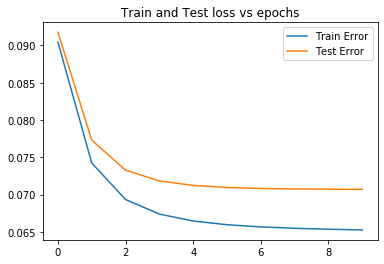

TEST Accuracy:  83.33333333333334


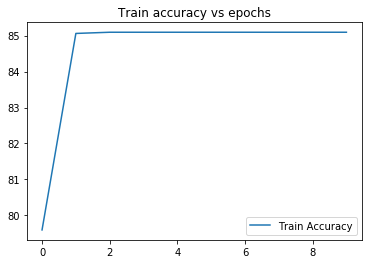

In [2]:
import numpy as np
from matplotlib import pyplot as plt 
from helperFunctions import *
import pandas as pd
from sklearn.model_selection import train_test_split

class Model:
    def __init__(self):
        self.model = None
        self.target = None
        self.features = None
        self.data = None
        self.testX = None
        self.testY = None
        self.trainX = None
        self.trainY = None
        
    def _readDataset(self, filename):
        self.data = pd.read_csv(filename)

    def _dropNulls(self):
        self.data.drop(["education"], axis = 1, inplace = True) #dropping this improved accuracy
        self.data.dropna(inplace = True)
    
    def _saveProcessedData(self):
        self.data = self.data.apply(lambda x: normalize(x))
        self.features = self.data.drop("TenYearCHD", axis = 1)
        self.target = self.data.TenYearCHD
        self.data.to_csv("../data/processedData.csv")
    
    def _trainTestSplit(self):
        self.trainX, self.testX, self.trainY, self.testY = train_test_split(self.features, self.target, test_size=0.2)
        return self.trainX, self.testX, self.trainY, self.testY

    def preProcessing(self, filename):
        self._readDataset(filename)
        self._dropNulls()
        self.data.reset_index(drop = True)
        self._saveProcessedData()
        self._trainTestSplit()  
      
model = Model()
model.preProcessing("../data/framingham.csv")
trainX, testX, trainY, testY = model._trainTestSplit()
trainY = np.array(trainY).reshape(-1, 1)
train = [trainX, trainY]
testY = np.array(testY).reshape(-1, 1)

test = [testX, testY]
trainError = []
trainAccuracy = []
testError = []


class MyNeuralNet:
    def __init__(self, layerArray):
        
        """ 
        layerArray: 
            array of dimensions of layers. 
            size of layerArray is the number of layers in our network
        """
        trainError = []
        trainAccuracy = []
        testError = []


        self.layers = layerArray #layes in our network
        self.B = [] #bias matrix
        self.W = [] #weights matrix
        self.input = None 

        for layerNum in range(1, len(layerArray)): #1st layer is input so we exclude that
            biasVector = np.zeros((layerArray[layerNum], 1)) #bias zero initialized 
            self.B.append(biasVector)
            weightsMatrix = np.random.normal(loc = 0, scale = 1, size = (layerArray[layerNum], layerArray[layerNum-1])) #weights initialized with normal dist
            self.W.append(weightsMatrix)

    
    def netSize(self):
        """ 
        number of layers in the network excluding the input layer
        """    
        return len(self.layers) - 1
    
    def activateLayer(self, z):
        """
        applies activation function to the layer z. 
        activation : sigmiod
        """
        activatedLayer = sigmoid(z)
        return activatedLayer
    
    def derivatieActivateLayer(self, z):
        """ 
        applies derivate of activation function to the layer z. 
        activation : sigmiod
        """
        z = np.array(z)
        sigmoid = self.activateLayer(z)
        return sigmoid*(1-sigmoid)


    def forwardPass(self, layer):
        """
        passes through the network, calculates linear score and then applies sigmoid to it.
        """
        for i in range(self.netSize()):
            layer = np.dot(layer, self.W[i].T) + self.B[i].T
            layer = self.activateLayer(layer)
        return layer
    
    def backPropagate(self, x, y):
        """
        Backpropagates through the network to calculate gradients. 
        """

        #dW and dB hold the gradients of cost wrt. weights and biases. initilially zero
        dW = []
        dB = []
        for i in range(self.netSize()):
            dW.append(np.zeros(self.W[i].shape))
            dB.append(np.zeros(self.B[i].shape))
        #(10, 14) (1, 10)

        outputLayers = [] #Z's
        activeOutputLayers = [] #Sigmoid of Z's or g(Z)
        n = self.netSize()
        activeOutput = x #input layer 
        activeOutputLayers.append(activeOutput)
        
        for b,w in zip(self.B, self.W):
            output = np.dot(w, activeOutput) + b
            outputLayers.append(output)
            activeOutput = self.activateLayer(output)
            activeOutputLayers.append(activeOutput)
        
        outputLayers = np.array(outputLayers)
        activeOutputLayers = np.array(activeOutputLayers)
        

        dZ = derivateCost(activeOutput, y) * self.derivatieActivateLayer(output)
        dW[n-1] = np.dot(dZ, activeOutputLayers[-2].T)
        dB[n-1] = dZ

        for l in range(n-1):
            dZ = np.dot(self.W[n-1-l].T, dZ) * self.derivatieActivateLayer(outputLayers[n-2-l])
            dB[l] = dZ
            dW[l] = np.dot(dZ , activeOutputLayers[max(0,n-3-l)].T)

        return (np.array(dB), np.array(dW))
   

    def train(self, train, test, epochs, batchSize, learningRate, validation = None):
        """
        Trains the network using mini-batch gradient descent.
        """

        for i in range(epochs):
            for batch in dataIter(batchSize, train):
                xBatch, yBatch = batch[0], batch[1]
                dW = []
                dB = []
                #print(xBatch)

                #initialize gradients
                for j in range(self.netSize()):
                    dW.append(np.zeros(self.W[j].shape))
                    dB.append(np.zeros(self.B[j].shape))
                
                for x, y in zip(xBatch, yBatch):
                    x = x.reshape(14, 1)
                    #obtain gradients by backpropagating
                    gradB, gradW = self.backPropagate(x, y)
                    n = self.netSize()

                    #summing weights and biases for all examples in the mini batch
                    dW = [w + gradw for w, gradw in zip(dW, gradW)]
                    dB = [b + gradb for b, gradb in zip(dB, gradB)]

                for j in range(self.netSize()):
                    self.W[j] = self.W[j] - (learningRate/batchSize)*dW[j]
                    self.B[j] = self.B[j] - (learningRate/batchSize)*dB[j]
            
            trainError.append(calculateError(self, train))
            trainAccuracy.append(accuracy(self.forwardPass(train[0]), train[1]))
            testError.append(calculateError(self, test))

            print("Epoch no: {}\n----------".format(i+1))
            print("Train Error: {0} \n Train Accuracy: {1} \n Test Error: {2} \n \n \n".format(trainError[i], trainAccuracy[i], testError[i]))
        plt.plot(range(epochs), trainError, label = 'Train Error')
        plt.plot(range(epochs), testError, label = 'Test Error')
        plt.legend()
        plt.title("Train and Test loss vs epochs")
        plt.show()

        plt.plot(range(epochs), trainAccuracy, label = 'Train Accuracy')
        plt.legend()
        plt.title("Train accuracy vs epochs")
        #plt.show()
        
        print("TEST Accuracy: ", accuracy(self.forwardPass(test[0]), test[1]))

network = MyNeuralNet([train[0].shape[1], 10, 1])
network.train(train, test, 10, 10, 0.01)